In [1]:
from __future__ import unicode_literals,print_function,division#division执行精确除法
from io import open
import glob
import os#导入标准库os
import unicodedata
import string
def findFiles(path) : return glob.glob(path)# glob.glob()返回的是列表 list类型。是所有路径下的符合条件的文件名的列表
print(findFiles('data/names/*.txt'))

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [2]:
all_letters = string.ascii_letters+".,;"
n_letters = len(all_letters)#所有字母的数量
def unicodeToAscii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD',s)
    if unicodedata.category(c)!='Mn'# Mn表示有附加符
    and c in all_letters)
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [3]:
category_lines = {}#词典，存储language：lines
all_categories = []#
def readLines(filename):#readlines 从文件里读出每一行
    lines = open(filename,encoding = 'utf-8').read().strip().split('\n')#read（）读取文件，strip（）去除字符串首尾空格或换行符，split（'\n）'返回分割后的字符串列表
    return [unicodeToAscii(line) for line in lines]#列表中每一列都转换为标准英文字母

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]#splitext返回一个表示指定路径名的根和扩展部分的元组,[0] 代表根部分 os.path.basename返回path最后的文件名这里是把具体的文件名与后缀分割开了
    all_categories.append(category)#将每一个语种都加入分类的列表中
    lines = readLines(filename)#每一个语种的每一列都读出来
    category_lines[category] = lines#将语种这个类别与他的列存入词典的键值对中

n_categories = len(all_categories)
print(all_categories)
print(category_lines['Japanese'])
    
    

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara', 'Aizawa', 'Ajibana', 'Akaike', 'Akamatsu', 'Akatsuka', 'Akechi', 'Akera', 'Akimoto', 'Akita', 'Akiyama', 'Akutagawa', 'Amagawa', 'Amaya', 'Amori', 'Anami', 'Ando', 'Anzai', 'Aoki', 'Arai', 'Arakawa', 'Araki', 'Arakida', 'Arato', 'Arihyoshi', 'Arishima', 'Arita', 'Ariwa', 'Ariwara', 'Asahara', 'Asahi', 'Asai', 'Asano', 'Asanuma', 'Asari', 'Ashia', 'Ashida', 'Ashikaga', 'Asuhara', 'Atshushi', 'Ayabito', 'Ayugai', 'Baba', 'Baisotei', 'Bando', 'Bunya', 'Chiba', 'Chikamatsu', 'Chikanatsu', 'Chino', 'Chishu', 'Choshi', 'Daishi', 'Dan', 'Date', 'Dazai', 'Deguchi', 'Deushi', 'Doi', 'Ebina', 'Ebisawa', 'Eda', 'Egami', 'Eguchi', 'Ekiguchi', 'Endo', 'Endoso', 'Enoki', 'Enomoto', 'Erizawa', 'Eto', 'Etsuko', 'Ezakiya', 'Fuchida', 'Fugunaga', 'Fujikage', 'Fujimak

In [4]:
#进行one-hot编码
#令字母表中的字母数量为n_letters，一个字母的向量是1xn_letters维，一个长度为line_length的单词,向量维度为line_lengthxn_letters
import torch
device = torch.device('cuda:0')
#返回字母letter的索引index
def letterToIndex(letter):
    return all_letters.find(letter)
#把一个字母编码为tensor
def letterToTensor(letter):
    tensor = torch.zeros(1,n_letters)#1行 n_letter列
    tensor[0][letterToIndex(letter)] = 1
    return tensor.to(device)#tensor信息传给GPU，方便运行
#把一个单词编码成tensor
def lineToTensor(line):
    tensor = torch.zeros(len(line),1,n_letters)
    #遍历单词中的所有字母，对每个字母letter他的索引设定为1，其他都是0
    for li,letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor.to(device)    

print(letterToTensor('J'))
print(lineToTensor('Augustine').size())
    

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]], device='cuda:0')
torch.Size([9, 1, 55])


In [5]:
#搭建模型
import torch.nn as nn

class RNN(nn.Module):
    #初始化定义每一层的输入大小，输出大小
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
    #前向传播过程
    def forward(self,input,hidden):
        combined = torch.cat((input,hidden),1)#将xt与上一步的h（t-1）拼接在一起dim=1；按行拼接
        hidden = self.i2h(combined)#[xt,ht-1]*Wh 变成新的隐藏层ht = Wh[xt,ht-1]
        output = self.i2o(combined)#[xt,ht-1]*Wo 得到输出Wo[xt,ht-1]
        output = self.softmax(output)#通过一个softmax函数，把输出Ot变为预测值 logsoftmax(Ot)
        return output,hidden
    #初始化隐藏层状态
    def initHidden(self):
        return torch.zeros(1,self.hidden_size).to(device)
    
n_hidden = 128#隐藏层的向量维度为128维
rnn = RNN(n_letters,n_hidden,n_categories)#input hidden output
rnn = rnn.to(device)

    


In [6]:
input = letterToTensor('A')
hidden = torch.zeros(1,n_hidden).to(device)
output,next_hidden = rnn(input,hidden)
print(output)

tensor([[-2.9740, -2.9118, -2.7862, -2.7790, -2.8678, -2.8890, -2.9970, -3.0000,
         -2.9323, -2.8478, -2.8657, -2.9037, -2.9072, -2.9795, -2.7830, -2.8720,
         -2.9151, -2.8560]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1,n_hidden).to(device)
output,next_hidden = rnn(input[0],hidden)
print(output)

tensor([[-2.9740, -2.9118, -2.7862, -2.7790, -2.8678, -2.8890, -2.9970, -3.0000,
         -2.9323, -2.8478, -2.8657, -2.9037, -2.9072, -2.9795, -2.7830, -2.8720,
         -2.9151, -2.8560]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [8]:
# define categoryFromOutput() 可以把yt变成对应的类别， 用Tensor.topk选出18个概率中，概率最大的下标 category_i就是yt的类别
def categoryFromOutput(output):
    top_n,top_i = output.topk(1)#torch.topk(input, k, dim=None, largest=True, sorted=True, out=None) -> (Tensor, LongTensor) top_n返回最大值, top_i返回最大值索引
    category_i = top_i[0].item()
    return  all_categories[category_i],category_i

In [9]:
import random
def randomChoice(l):#从所有数据中随机采样
    return l[random.randint(0,len(l)-1)]#random.randint 返回0，len(l)-1 中的任意整数
def randomTrainingExample():
    category = randomChoice(all_categories)#在类别中随机采样
    line = randomChoice(category_lines[category])#类别中line随机采样
    category_tensor = torch.tensor([all_categories.index(category)],dtype=torch.long).to(device)
    line_tensor = lineToTensor(line)
    return category,line,category_tensor,line_tensor
for i in range(10):
    category,line,category_tensor,line_tensor = randomTrainingExample()
    print('category= ',category,'/line= ',line)
    




category=  Arabic /line=  Ghannam
category=  Greek /line=  Kyritsis
category=  Spanish /line=  Estevez
category=  Spanish /line=  Cardona
category=  French /line=  Tremblay
category=  Dutch /line=  Dale
category=  German /line=  Hirsch
category=  Czech /line=  Psik
category=  Russian /line=  Awksentiewsky
category=  Italian /line=  Moretti


In [10]:
#定义损失函数NLLLoss,lr 0.005
#创建输入tensor和目标tensor
#初始化隐藏层状态 h0
#输入每个字母Xt
#保存下一个字母需要的隐藏层状态Ht
#将模型预测的输出yp与目标yt进行对比
#梯度反向传播
#返回输出和损失函数
criterion = nn.NLLLoss()#官方集成的损失函数
learning_rate = 0.005

def train(category_tensor,line_tensor):
     # 初始化隐藏层张量
    hidden = rnn.initHidden()
    
    rnn.zero_grad()# 梯度初始化为0
    # RNN循环
    for i in range(line_tensor.size()[0]):#line_tensor.size()[0]表示维度
        output,hidden = rnn(line_tensor[i],hidden)
    loss = criterion(output,category_tensor)
    loss.backward()
    
    #更新参数
    for p in rnn.parameters():#Module.parameters获取网络参数
        # 将参数的张量表示与参数的梯度进行乘法运算并乘以学习率，结果家到参数上并进行覆盖更新(下划线add_)
        p.data.add_(p.grad.data,alpha=-learning_rate)
        
    return output,loss.item()
    
    

In [11]:
import time
import math
n_iters = 100000#训练迭代次数
print_every = 5000#结果打印时间间隔
plot_every = 1000#绘制损失曲线上的制图间隔
current_loss = 0
all_losses = []

def timeSince(since):#计算训练时间
    now = time.time()
    s = now - since
    return '%dm%ds'%(s//60,s%60)#//整数除法
start = time.time()

for iter in range(1,n_iters + 1):
    category,line,category_tensor,line_tensor = randomTrainingExample()#  采样 ，生成张量
    output,loss = train(category_tensor,line_tensor)
    current_loss += loss
    
    if iter%print_every == 0:
        guess,guess_i = categoryFromOutput(output)
        correct ='√'if guess ==category else 'x(%s)'%category
        print('%d %d%%(%s) %.4f %s /%s%s'%
             (iter,iter/n_iters*100,timeSince(start),loss,line,guess,correct))
    if iter%plot_every ==0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0
        
    
    

5000 5%(0m9s) 2.4888 To /Chinesex(Vietnamese)
10000 10%(0m17s) 2.6422 Ouchi /Italianx(Japanese)
15000 15%(0m26s) 0.2515 Ashikaga /Japanese√
20000 20%(0m35s) 1.7942 Palumbo /Portuguesex(Italian)
25000 25%(0m44s) 1.0109 Shan /Chinese√
30000 30%(0m53s) 2.2918 Johnston /Englishx(Scottish)
35000 35%(1m1s) 3.2828 Munro /Portuguesex(Scottish)
40000 40%(1m10s) 0.4913 Ozawa /Japanese√
45000 45%(1m19s) 1.0647 Nader /Arabic√
50000 50%(1m27s) 3.2471 Garrastazu /Japanesex(Spanish)
55000 55%(1m36s) 0.9187 Abasolo /Spanish√
60000 60%(1m45s) 0.6167 Meng /Chinese√
65000 65%(1m54s) 1.2056 Ortiz /Spanish√
70000 70%(2m2s) 2.6109 Guttridge /Greekx(English)
75000 75%(2m11s) 0.7396 Araullo /Portuguese√
80000 80%(2m20s) 0.4651 Kim /Korean√
85000 85%(2m29s) 1.1911 Tahan /Arabic√
90000 90%(2m38s) 0.2178 Mustafa /Arabic√
95000 95%(2m47s) 1.8043 Simoes /Arabicx(Portuguese)
100000 100%(2m56s) 1.5762 Sitz /German√


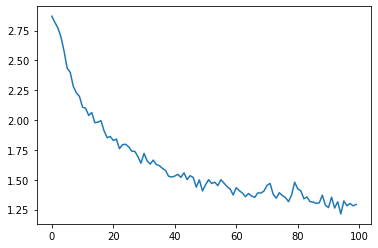

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_losses)

In [13]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output,hidden = rnn(line_tensor[i],hidden)
    return output
def predict(input_line,n_predictions = 3):
    print('\n>%s'%input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        topv,topi = output.topk(n_predictions,1,True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f)%s'%(value,all_categories[category_index]))
            #predictions.append([value,all_categories[category_index]])
predict("Doveshy")
predict('Jackson')
predict('Satoshi')


>Doveshy
(-1.34)French
(-1.93)Czech
(-2.47)English

>Jackson
(-0.23)Scottish
(-2.13)English
(-3.39)Russian

>Satoshi
(-0.98)Japanese
(-1.22)Italian
(-2.44)Arabic


C:\Users\MNeilDiane\Anaconda3\envs\Augustine\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\MNeilDiane\Anaconda3\envs\Augustine\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


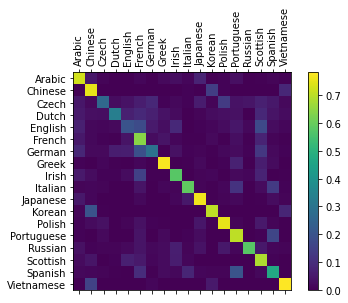

In [15]:
confusion = torch.zeros(n_categories,n_categories)
n_confusion = 10000
for i in range(n_confusion):
    category, line, category_tensor,line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess,guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i]/confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels(['']+all_categories,rotation=90)
ax.set_yticklabels(['']+all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()
